In [1]:
import os
import random
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import wandb

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42

In [2]:
# логинимся в вандбе
wandb.login(key='37d77515db6a159f86f6c7c987b7dc0eca96f53e')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Ссылка на wandb: https://wandb.ai/maximkiselev8376/aaa%20lstm%20final%20model?nw=nwusermaximkiselev8376

# Функции

In [3]:
def set_seed(seed: int):
    """Фиксация всех генераторов случайных чисел. Нужно для воспроизводимости."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
class LSTMWithAttention(nn.Module):
    """Класс с моделью LSTM с attention-пулингом."""
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        use_bidirectional = False,
        dropout: float = 0.1,
        hidden_fc_size: int = 128
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim // 2,
                           batch_first=True,
                           bidirectional=use_bidirectional,
                           dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_fc_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_fc_size, output_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def attention(self, lstm_output, final_state):
        merged_state = torch.cat([s for s in final_state], 1) # стакаем два вектора скрытых состояний (2 т.к. lstm двунаправленная)
        merged_state = merged_state.squeeze(0).unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state) # batch matrix-matrix product of matrices
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)

        attn_output = self.attention(output, hidden)

        return self.mlp(attn_output.squeeze(0))

In [5]:
EMPTY_TOKEN = 0 # токен пустого символа
NOT_IN_VOCAB = 1 # токен для слов не из словаря
TARGET_ENCODING = {
    'trebuet_remonta': 0,
    'kosmeticheskii': 1,
    'evro': 2,
    'dizainerskii': 3
}

class CustomDataset(Dataset):
    """Датасет для модели."""
    def __init__(
        self,
        texts: pd.Series,
        targets: pd.Series,
        tokenizer: callable,
        encode_mapping: dict,
        max_tokens_len: int = None
    ):
        self.texts = np.array(texts)
        self.targets = np.array(targets)
        self.max_tokens_len = max_tokens_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """Описание работы:
            1. Токенизируем текст в токены.
            2. Токены кодируем в цифры (так требует nn.Embedding).
            3. Ограничиваем длину последовательности до заданного значения.
            4. Кодируем таргеты.
        """
        text = self.texts[idx]
        text_tokens = tokenizer(text)
        text_tokens_enc = [encode_mapping.get(token, NOT_IN_VOCAB)
                           for token in text_tokens]
        
        if self.max_tokens_len is not None:
            text_tokens_enc = text_tokens_enc[:self.max_tokens_len] # берем первые `max_tokens_len` токенов

        target = self.targets[idx]
        target = TARGET_ENCODING[target]
        return text_tokens_enc, target

In [6]:
def collate_batch(batch):
    """Обработка батча для лоадера:
        - Вычисляем длину самой большой последовательности в батче.
        - Добавляем паддинг внутри батча (чтобы последовательности были одинаковой длины).
    """
    max_tokens_size = 0
    for tokens, target in batch:
        max_tokens_size = max(max_tokens_size, len(tokens))

    tokens_batch = []
    targets_batch = []
    # заполняем пустыми токенами
    for tokens, target in batch:
        tokens_batch.append(
            tokens + [EMPTY_TOKEN] * (max_tokens_size - len(tokens))
        )
        targets_batch.append(target)

    return torch.Tensor(tokens_batch).long(), torch.Tensor(targets_batch).long()

In [7]:
def plot_progress(train_losses, train_roc_aucs, test_loss, test_roc_aucs):
    """Функция для отрисовки процесса обучения. На обучение не влияет!"""
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    
#     Для ограничения графика loss можно пользоваться set_ylim:
    ax1.set_ylim([-0.05, 2])

    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_roc_aucs, label='train accuracy')
    ax2.plot(test_roc_aucs, label='test accuracy')
    ax2.plot(np.ones_like(train_roc_aucs), '--', label='100% accuracy')
    ax2.plot(np.ones_like(train_roc_aucs) * 0.5, '--', label='50% accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

In [8]:
def train_model(
    exp_name: str,
    model: nn.Module,
    lr: float  = None,
    epochs: int  = None,
    lr_step: int  = None,
    lr_gamma: float = None,
    train_dataloader: DataLoader = None,
    val_dataloader: DataLoader = None
):
    """Trainer для модели:
        - Запускает логгирование в вандб.
        - Задает оптимизатор, планировщик согласно входной конфигурации.
        - Запускает процесс обучения на заданное число эпох.
    """
    run = wandb.init(
    project='aaa lstm final model',
    name=exp_name,
    config={
        'model': model.__class__.__name__,
        'lr': lr,
        'epochs': epochs,
        'lr_step': lr_step,
        'lr_gamma': lr_gamma,
        'dataloader_class_name': train_dataloader.__class__.__name__
        }
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer,
        step_size=lr_step,
        gamma=lr_gamma,
        last_epoch=-1
    )
    loss = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    best_accuracy = 0

    for epoch in range(epochs):
        for i, (emb_tokens_train, targets_train) in tqdm(enumerate(train_dataloader)):
            model.train()

            emb_tokens_train = emb_tokens_train.to(DEVICE)
            targets_train = targets_train.to(DEVICE)

            optimizer.zero_grad()

            pred_train = model(emb_tokens_train)
            loss_train = loss(pred_train, targets_train)

            loss_train.backward()
            optimizer.step()
            scheduler.step()

            train_losses.append(loss_train.detach().cpu())
            pred_label_train = torch.argmax(pred_train, dim=1)
            train_accuracy.append((pred_label_train == targets_train).detach().cpu().numpy().mean())

            emb_tokens_val, targets_val = next(iter(val_dataloader))
            model.eval()
            with torch.no_grad():
                emb_tokens_val = emb_tokens_val.to(DEVICE)
                targets_val = targets_val.to(DEVICE)

                pred_val = model(emb_tokens_val)
                loss_val = loss(pred_val, targets_val)

                val_losses.append(loss_val.detach().cpu())
                pred_label_val = torch.argmax(pred_val, dim=1)
                val_accuracy.append((pred_label_val == targets_val).detach().cpu().numpy().mean())

                if i % 250 == 0:
                    plot_progress(train_losses, train_accuracy, val_losses, val_accuracy)
                    current_lr = scheduler.optimizer.param_groups[0]['lr']
                    print(f'epoch: {epoch + 1} / {epochs}, lr: {current_lr}')

        
        cur_train_accuracy = np.mean(train_accuracy[-i:])
        cur_train_loss = np.mean(train_losses[-i:])
        cur_val_accuracy = np.mean(val_accuracy[-i:])
        cur_val_loss = np.mean(val_losses[-i:])
        if np.mean(val_accuracy[-i:]) > best_accuracy:
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            best_accuracy = np.mean(val_accuracy[-i:])
            
        wandb.log(
            {'train_accuracy': cur_train_accuracy,
             'train_loss': cur_train_loss,
             'val_accuracy': cur_val_accuracy,
             'val_loss': cur_val_loss}
        )

    print(f'Best accuracy: {best_accuracy}')
    wandb.save('/kaggle/working/best_model.pth')
    wandb.finish()

# Загрузка данных

In [9]:
df = pd.read_csv('/kaggle/input/final-project-data/data.csv') # изначальный датасет от Артема
df_splitting = pd.read_csv('/kaggle/input/final-project-data/splitting_sample.csv') # разбиение на train / val / test
df_tfidf = pd.read_csv('/kaggle/input/final-project-data/tfidf_lr_prediction.csv') # предсказания tf-idf логрега (на процесс обучения не влияют)

df = df.merge(df_splitting, on='item_id', how='left')
df = df.merge(df_tfidf, on='item_id', how='left')

# Подготовка к обучению

## Создаем словарь, задаем токенизатор

In [10]:
vectorizer = CountVectorizer(
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b', # стандартная токенизация из sklearn
    ngram_range=(1, 1),
    analyzer='word', # токенизация по словам
    max_df=1.0,
    min_df=10, # ставим ограничение на минимальное количество встреч в корпусе
    max_features=None
)
vectorizer.fit(df.loc[df['sample_part'] == 'train', 'description'])

# создаем токенизатор
tokenizer = vectorizer.build_tokenizer()
# задаем энкодинг
encode_mapping = {word: i+2 for i, word in enumerate(vectorizer.vocabulary_)}

## Создаем даталоадеры

In [11]:
train_dataset = CustomDataset(
    texts=df.loc[df['sample_part'] == 'train', 'description'],
    targets=df.loc[df['sample_part'] == 'train', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
val_dataset = CustomDataset(
    texts=df.loc[df['sample_part'] == 'val', 'description'],
    targets=df.loc[df['sample_part'] == 'val', 'attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)
full_dataset = CustomDataset(# датасет для всей выборки (нужен для инференса)
    texts=df['description'],
    targets=df['attr_value_name'],
    tokenizer=tokenizer,
    encode_mapping=encode_mapping
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_batch)
full_dataloader = DataLoader(full_dataset, batch_size=128, shuffle=False, collate_fn=collate_batch)

# Запускаем обучение лучшей модели (по результатам экспериментов)

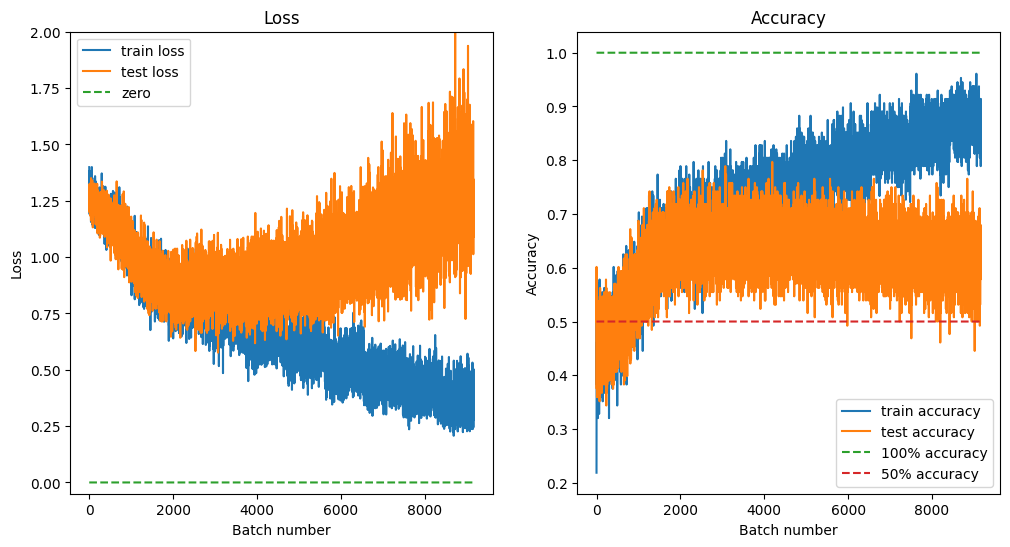

753it [01:16,  5.25it/s]

epoch: 10 / 10, lr: 0.00015906436205108607


935it [01:34,  9.87it/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Best accuracy: 0.6495332574946466


train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▆████▇▇▇▇
val_loss,▆▂▁▁▁▂▃▅▆█
train_accuracy,0.87241
train_loss,0.35862
val_accuracy,0.61912
val_loss,1.29039


In [12]:
set_seed(RANDOM_SEED)

model = LSTMWithAttention(
    vocab_size=len(encode_mapping) + 2,
    embedding_dim=256, # размерность эмбеддингов
    hidden_dim=256,    # размерность скрытого слоя lstm
    output_dim=4,      # классификация на 4 класса (дана условиями задачи)
    n_layers=1,        # количество слоев lstm
    use_bidirectional=True, # сетка двунаправленная
    dropout=0.1,       # дропаут в lstm и в линейных слоях после неё
    hidden_fc_size=32  # размерность скрытого линейного слоя
).to(DEVICE)

train_model(exp_name='1 layers with scheduler and other params', model=model, lr=0.001, epochs=10, lr_step=100, lr_gamma=0.98, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# Инференс лучшей модели

In [35]:
# загружаем веса лучшей модели
api = wandb.Api()
run = api.run('maximkiselev8376/aaa lstm final model/yjs621rz') # берем лучшую модель (можно подгрузить из локального хранилиза)
for file in run.files():
    if 'best_model.pth' in str(file):
        file.download()

In [36]:
# не переопределяя модель устанавливаем веса лучшей попытки
model.load_state_dict(torch.load('/kaggle/working/working/best_model.pth'))

<All keys matched successfully>

In [37]:
TARGET_DECODING = {v: k for k, v in TARGET_ENCODING.items()}

preds = []
preds_proba = []

model.eval()
with torch.no_grad():
    for emb_tokens, _ in tqdm(full_dataloader):
        emb_tokens = emb_tokens.to(DEVICE)

        pred = model(emb_tokens)
        pred_label = torch.argmax(pred, dim=1)
        pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)[0] # вероятность ответа модели
        
        preds.append(pred_label.detach().cpu().tolist())
        preds_proba.append(pred_proba.detach().cpu().tolist())

preds = np.concatenate(preds)
df['lstm_predict'] = [TARGET_DECODING[label_id] for label_id in preds]
df['lstm_proba'] = np.concatenate(preds_proba)

100%|██████████| 1558/1558 [00:50<00:00, 30.93it/s]


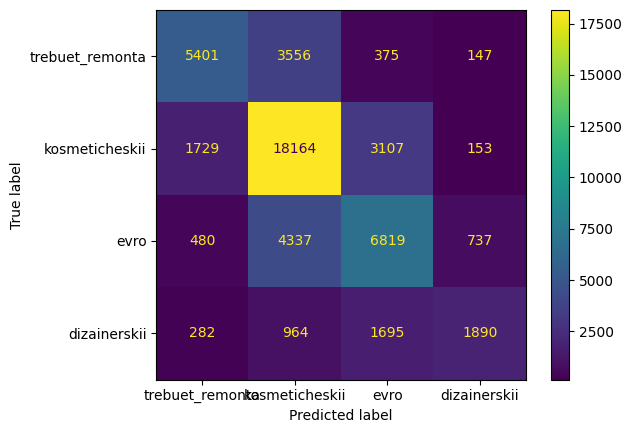

In [38]:
cm = confusion_matrix(
    df.loc[df['sample_part'] == 'test', 'attr_value_name'],
    df.loc[df['sample_part'] == 'test', 'lstm_predict'],
    labels=['trebuet_remonta', 'kosmeticheskii', 'evro', 'dizainerskii']
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(TARGET_ENCODING.keys()))
disp.plot()

# Подбираю порог для классификации (постобработка предсказаний)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


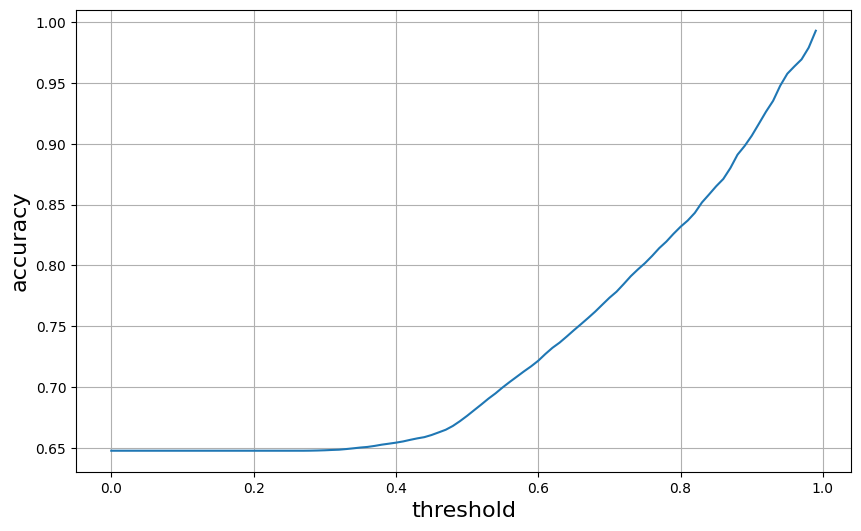

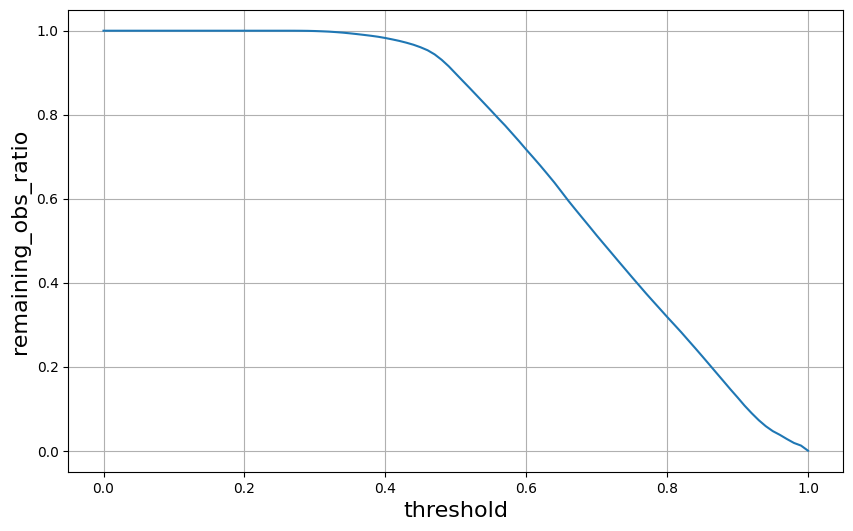

In [39]:
mask_test = df['sample_part'] == 'test'

threshold_list = []
accuracy_list = []
remaining_obs_ratio_list = []
for threshold in np.linspace(0, 1, 101):
    mask_confident_predictions = df['lstm_proba'] > threshold

    accuracy_confident = accuracy_score(
        y_pred=df.loc[mask_test & mask_confident_predictions, 'lstm_predict'],
        y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
    )
    threshold_list.append(threshold)
    accuracy_list.append(accuracy_confident)
    remaining_obs_ratio_list.append(mask_confident_predictions.mean())

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, accuracy_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.grid()
plt.show()

# зависимость accuracy от трешхолда
fig = plt.figure(figsize=(10, 6))
plt.plot(threshold_list, remaining_obs_ratio_list)
plt.xlabel('threshold', fontsize=16)
plt.ylabel('remaining_obs_ratio', fontsize=16)
plt.grid()
plt.show()

Графики похожи, на аналогичные графики для tf-idf

**Можем обрезать 30% самых неуверенных предсказаний и получить точность 0.72**

In [40]:
threshold = 0.6
mask_test = df['sample_part'] == 'test'
mask_confident_predictions = df['lstm_proba'] > threshold

accuracy_confident = accuracy_score(
    y_pred=df.loc[mask_test & mask_confident_predictions, 'lstm_predict'],
    y_true=df.loc[mask_test & mask_confident_predictions, 'attr_value_name']
)
accuracy_non_confident = accuracy_score(
    y_pred=df.loc[mask_test & ~mask_confident_predictions, 'lstm_predict'],
    y_true=df.loc[mask_test & ~mask_confident_predictions, 'attr_value_name']
)

print(f"""Доля уверенных предсказаний: {mask_confident_predictions.mean():.3f}""")
print(f"""accuracy по уверенным предсказаниям: {accuracy_confident:.3f}""")
print(f"""accuracy по неуверенным предсказаниям: {accuracy_non_confident:.3f}""")

Доля уверенных предсказаний: 0.717
accuracy по уверенным предсказаниям: 0.722
accuracy по неуверенным предсказаниям: 0.472


## Примеры, где модель ошибается

In [44]:
mask_test = df['sample_part'] == 'test'
mask_wrong = df['lstm_predict'] != df['attr_value_name']
mask_confident_predictions = df['lstm_proba'] > threshold # threshold==0.6

# ошибки на "уверенных" предсказания
for pred, true, desc in df.loc[mask_test & mask_wrong & mask_confident_predictions, ['lstm_predict', 'attr_value_name', 'description']].values[:10]:
    print(f'pred: {pred}, true: {true}\n\t{desc}', end='\n\n')

pred: kosmeticheskii, true: trebuet_remonta
	Собственник без комиссий, залог 70000 (можно разбить на 2 мес). До метро Яхромская 2 минуты пешком. Уважаемые Агенты звонить только в том случае если у Вас есть реальный клиент. Кто ищет по дешевле тоже просьба не беспокоить, строго без торга. 
Рассматриваются только граждане РФ, предпочтение семейной паре.
Квартира сдается на длительный срок. 
Современный монолитный дом (свечка 25 этажей) 2009г постройки, чистый подъезд с консьержем. Комнаты изолированные 19 и 12.5 кв/м, кухня 10.5 кв/м, коридор 9 кв/м, тамбур 5 кв/м, лоджия застеклена 3 кв/м. Окна пластиковые во двор, отличный Панорамный вид, муниципальный ремонт. Кондиционер в большой комнате, 2 металлических двери. 
Из мебели: 
Кухонный гарнитур, духовой шкаф, варочная панель, холодильник, кухонный стол.
В спальне двухспальная кровать и мини комод. Большая комната - мини открытая стенка. В коридорах шкаф купе и шкаф для одежды. 
70000р/мес строго без торга + Вода по счетчикам + Электриче

В большей части кейсов реальный лейбл не совпадает с описанием объявления